In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import xarray as xr
import matplotlib.pyplot as plt

import os
import numpy as np

In [2]:

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [3]:
class Fire_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations")
 
        self.filenames = self._get_files(suffix = '.npy')  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        
        image_path = os.path.join(self.images_directory, filename)
        mask_path = os.path.join(self.masks_directory, filename)
        
        image = torch.from_numpy(np.load(image_path))
        mask = torch.from_numpy(np.load(mask_path))
        
        sample = dict(image = image, mask = mask)
        
        

        return sample


    def _get_files(self, suffix):
        files = []
        
        if self.mode == 'train':
            dir_to_walk = os.path.join(self.root, 'images')
        elif self.mode == 'valid':
            dir_to_walk = os.path.join(self.root, 'annotations')
            
            
        for r,d,f in os.walk(dir_to_walk):
            for file in f:
                if file.endswith(suffix):
                    files.append(os.path.join(r,file))
        
        
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(files) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(files) if i % 10 == 0]

        filenames = [f.split('/')[-1] for f in filenames]
        return filenames
    
    def return_files(self):
        return self.filenames
    
    def _normalize(tensor):
        mean, std, var = torch.mean(tensor), torch.std(tensor), torch.var(tensor)

        return (tensor-mean)/std

In [4]:
def preprocess(dataset):
    def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0) -> np.ndarray:

        pad_size = target_length - array.shape[axis]

        if pad_size <= 0:
            return array

        npad = [(0, 0)] * array.ndim
        npad[axis] = (0, pad_size)

        return np.pad(array, pad_width=npad, mode='edge')
    
    expected_shape = dataset.CMI_C01.values.shape
    bands = list(dataset.data_vars)
    
    bad_bands = []
    for b in bands:
        if dataset[b].values.shape != expected_shape and b != 'fire_bool':
            bad_bands.append(b)

    dataset = dataset.drop(bad_bands)
    output = {}
    bands2 = list(dataset.data_vars)
    
    for b in bands2:
        if b != 'fire_bool':
            output[b] = np.squeeze(pad_along_axis(dataset[b].values, 64, axis = 1)[:,:,:64])
        
        else:
            output[b] = np.squeeze(pad_along_axis(dataset[b].values, 64, axis = 0)[:,:64])
    
    return output


In [5]:
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [6]:
def get_files(parent_dir, suffix):
    files = []
    for r,d,f in os.walk(parent_dir):
        for file in f:
            if file.endswith(suffix):
                files.append(os.path.join(r,file))

                
    return files

In [7]:
def drop_bands(batch):
    t = batch['image'].float()
    
    return torch.cat(((t[:,1:11,:,:], t[:,12:16,:,:],t[:,19:,:,:])), axis=1)

In [8]:
# files = get_files('../Data/Training/Stacked/take2', '.nc')

In [9]:
def normalize(np_arr):
    normalizes = []
    for band in np_arr:
       
        mini, maxi = np.min(band), np.max(band)
        
        normalized = (band - mini) / (maxi - mini)
        normalizes.append(normalized)
            
    
    
    return normalizes

In [13]:
for f in files:
    data = preprocess(xr.open_dataset(f))
    
    feature_names = list(data.keys())
    feature_names.remove('fire_bool')
    
    bool_remove = [f.startswith('DQF_') for f in feature_names]
    other_remove = ['goes_imager_projection','fire_bool', 'spatial_ref']

    feature_names = [d for (d, remove) in zip(feature_names, bool_remove) if not remove]


    feature_names = [k for k in feature_names if k not in other_remove]
    
    mask = data['fire_bool']
    
    features = np.array([data[f] for f in feature_names])
    
    features = np.stack(normalize(features))
    
    split = f.split('/')
    output_parent = '/'.join(split[:4])+'/pytorch2'
    
    
    
    
    np.save(f'{output_parent}/images/{split[-1]}', features)
    
    np.save(f'{output_parent}/annotations/{split[-1]}', np.expand_dims(mask,0))
    

In [10]:
output_parent = '../Data/Training/Stacked/pytorch/'
train_dataset = Fire_Dataset(output_parent, 'train')
valid_dataset = Fire_Dataset(output_parent, 'valid')
# test_dataset = Fire_Dataset(output_parent, 'test')

# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count() - 2 
train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=30, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)


Train size: 4614
Valid size: 513


In [15]:
# data = next(iter(train_dataloader))

In [11]:
unet = Unet(21, 1)
# unet.load_state_dict(torch.load('saved_models/Sep13/model1.pt'))
unet.load_state_dict(torch.load('saved_models/Sep13/model2.pt'))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr = 0.002)

In [12]:
unet

Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(21, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d

In [ ]:
bads = [0,11,16,17,18]

In [ ]:
losses = []
metrics = {'dice_met': [], 'dice_loss' : []}

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        t, labels = data['image'].float(), data['mask'].float()
        
        
        inputs = torch.cat(((t[:,1:11,:,:], t[:,12:16,:,:],t[:,19:,:,:])), axis=1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, labels)
                
        if torch.isnan(loss):
#             print(loss)
            print("Received nan loss, continuing")
            continue
            
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
       
        losses.append(loss.item())
        
        print(loss.item())
        
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            torch.save(unet.state_dict(), 'saved_models/Sep13/model1.pt')
            
            print("Starting accuracy assessment")
            for valid in valid_dataloader:
                x_test, y_true = drop_bands(valid), valid['mask']
                
                y_pred = unet(x_test)
                dice_met = dice_metric(y_pred, y_true)
#                 dice_loss = dice_loss(y_pred, y_true)
                metrics['dice_met'].append(dice_met)
#                 metrics['dice_loss'].append(dice_loss)

                print(f'Dice Metric: {dice_met}')
#                 print(f'Dice Loss: {dice_loss}')
            
        if epoch > 30:
            optimizer = torch.optim.Adam(unet.parameters(), lr = 0.001)
            
        


print('Finished Training')

0.2587897479534149
0.2337452620267868
0.2658543288707733
0.24793535470962524
0.2134399116039276
0.20733626186847687
0.20422562956809998
0.199208602309227
0.1981724053621292
0.20007739961147308
0.1821524053812027
Received nan loss, continuing
0.17844326794147491
0.16448089480400085
0.16554680466651917
0.17607349157333374
0.16330678761005402
0.1576204150915146
0.17099355161190033
0.151383638381958
[1,    20] loss: 0.002
Starting accuracy assessment
Dice Metric: 0.038898113752000384
Dice Metric: 0.058115124842410174
Dice Metric: 0.03267898790575885
Dice Metric: 0.03775637761230544
Dice Metric: nan
Dice Metric: 0.0499816105675418
Dice Metric: 0.04311669730643912
Dice Metric: 0.053264834317745924
Dice Metric: 0.03489775528673756
Dice Metric: 0.05804977251135941
Dice Metric: 0.03564788478329011
Dice Metric: 0.04850498716503387
Dice Metric: 0.03577681606430029
Dice Metric: 0.05043298239765918
Dice Metric: 0.049540218276851816
Dice Metric: 0.03765785405874682
Dice Metric: 0.037373378465915714


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Dice Metric: 0.03486258706835421
0.15125685930252075
0.15395532548427582
0.13242009282112122
0.17305833101272583
Received nan loss, continuing
0.1404564380645752
0.1235899105668068
0.12729030847549438
0.14030645787715912
0.1404620260000229
0.13550660014152527
0.12832863628864288
0.1202268898487091
0.1193988174200058
0.12409546971321106
0.12091071158647537
0.10484805703163147
0.14791056513786316
0.10597168654203415
0.12038049101829529
[1,    40] loss: 0.001
Starting accuracy assessment
Dice Metric: 0.03826955446663542
Dice Metric: 0.05789672338186034
Dice Metric: 0.03166468003241223
Dice Metric: 0.03700420585956555
Dice Metric: nan
Dice Metric: 0.049518585882098905
Dice Metric: 0.04253997263165652
Dice Metric: 0.05227141742249808
Dice Metric: 0.033503572621982954
Dice Metric: 0.05532134705437804
Dice Metric: 0.03490553912669579
Dice Metric: 0.046413342840085706
Dice Metric: 0.034760001075592115
Dice Metric: 0.049937877997023615
Dice Metric: 0.0484669836779831
Dice Metric: 0.037433012303

In [72]:
torch.nn.Softmax(pred[i][0])

Softmax(
  dim=tensor([[-8.3775, -8.3696, -8.1510,  ..., -8.6244, -8.5331, -8.1959],
          [-8.4071, -8.8607, -8.5371,  ..., -8.4006, -8.3034, -8.1263],
          [-8.2717, -8.5155, -7.8887,  ..., -8.2151, -8.1509, -7.8388],
          ...,
          [-8.6734, -8.6182, -8.2574,  ..., -8.2281, -8.1740, -7.5614],
          [-8.4602, -8.3007, -8.0644,  ..., -8.2208, -8.0621, -7.5535],
          [-8.2089, -8.1673, -8.0203,  ..., -7.7664, -7.7596, -7.6203]],
         grad_fn=<SelectBackward0>)
)

In [12]:
valid_data = next(iter(valid_dataloader))
pred = unet(drop_bands(valid_data))





In [15]:
pred[i][0].detach().shape

torch.Size([64, 64])

In [26]:
for tensor in pred.detach():
    print(tensor[0].shape)

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])


In [47]:
!mkdir numpy_outputs/softmax

In [48]:
!ls numpy_outputs

raw     softmax


In [51]:
np.save()

array([[ -8.307636 , -11.3975935, -13.099534 , ..., -16.128384 ,
        -14.691085 , -11.857966 ],
       [-10.340693 , -13.84356  , -15.090188 , ..., -15.759682 ,
        -14.467448 , -12.624588 ],
       [-12.428163 , -15.244095 , -15.965642 , ..., -15.607488 ,
        -14.824792 , -13.518164 ],
       ...,
       [-16.487679 , -19.431742 , -22.494713 , ..., -23.500328 ,
        -21.668386 , -16.108936 ],
       [-16.574003 , -19.58226  , -22.482494 , ..., -25.228487 ,
        -23.057417 , -16.292118 ],
       [-15.401483 , -18.562773 , -21.465141 , ..., -23.50031  ,
        -21.327738 , -14.666277 ]], dtype=float32)

In [64]:
!mkdir numpy_outputs/real

In [65]:
!ls numpy_outputs

raw     real    softmax


In [67]:
# convert to numpy, download raw arrays and softmax arrays to send to adam

predicted  = pred.detach()
m = nn.Softmax(dim=1)

for i, tensor in enumerate(predicted):
    raw = tensor[0].numpy()
    soft = m(tensor).numpy()[0]
    
    
    np.save(f'numpy_outputs/raw/{str(i)}', raw)
    
    np.save(f'numpy_outputs/softmax/{str(i)}', soft)
    
    real = valid_data['mask'][i][0]
    
    np.save(f'numpy_outputs/real/{str(i)}', real)


In [69]:
!echo [29,6,13,1415,16,21,22,23,24,25,26,28,29] > numpy_outputs/good_outputs.txt

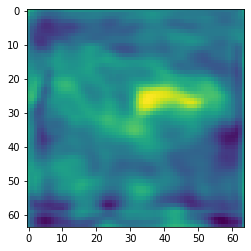

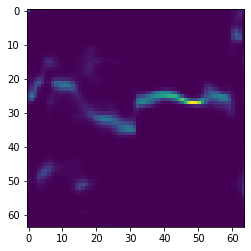

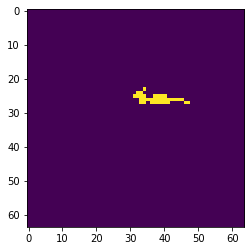

In [70]:
i = 29
raw = np.load(f'numpy_outputs/raw/{i}.npy')
soft = np.load(f'numpy_outputs/softmax/{i}.npy')
real = np.load(f'numpy_outputs/real/{i}.npy')


plt.imshow(raw)
plt.show()
plt.imshow(soft)
plt.show()
plt.imshow(real)

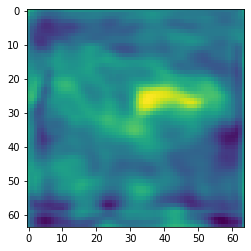

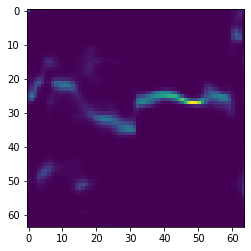

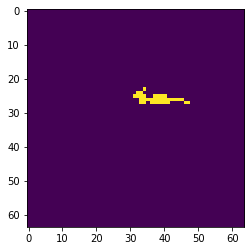

In [34]:
i = 29
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

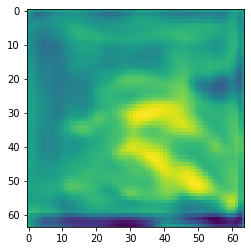

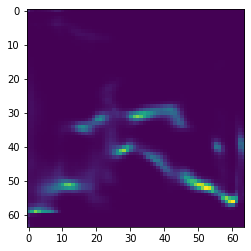

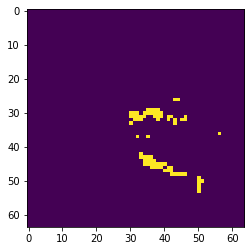

In [13]:
i = 6
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

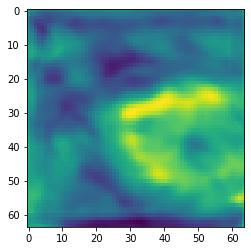

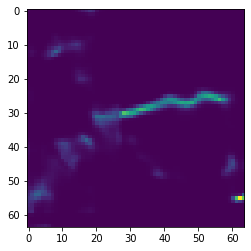

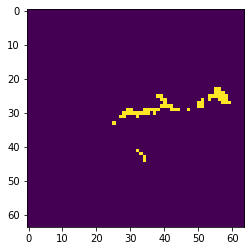

In [139]:
i = 13
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

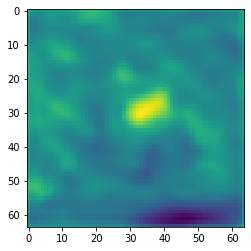

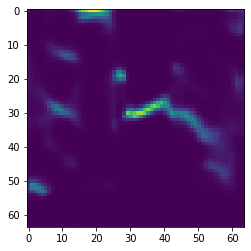

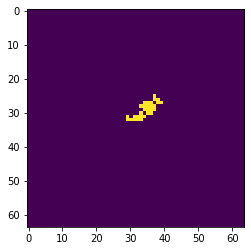

In [30]:
i = 14
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

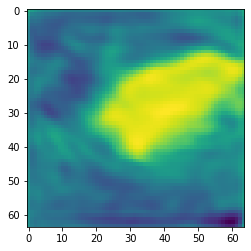

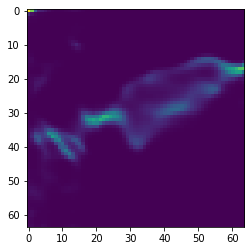

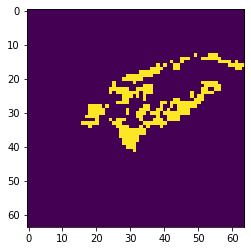

In [31]:
i = 15
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

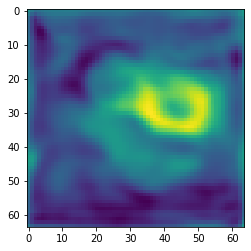

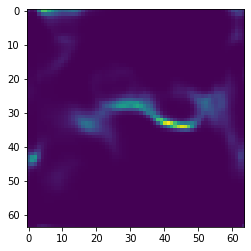

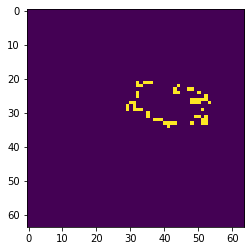

In [32]:
i = 16
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

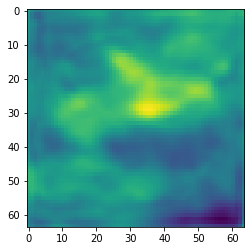

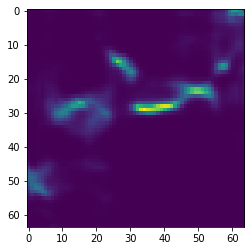

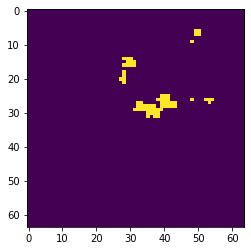

In [37]:
i = 21
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

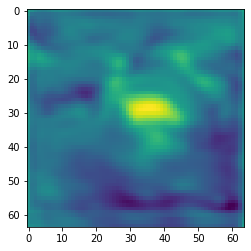

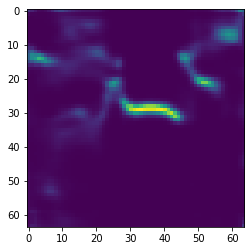

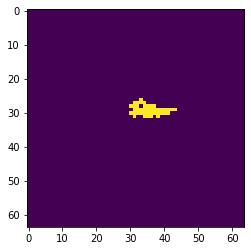

In [38]:
i = 22
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

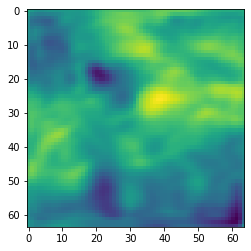

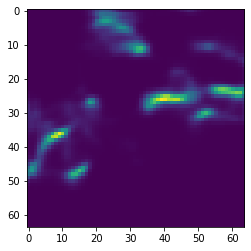

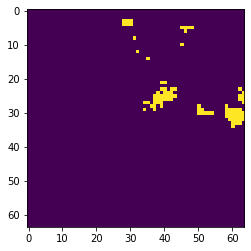

In [39]:
i = 23
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

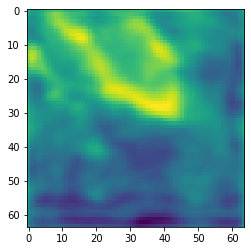

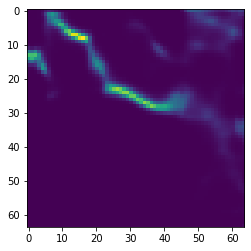

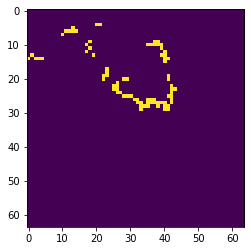

In [40]:
i = 24
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

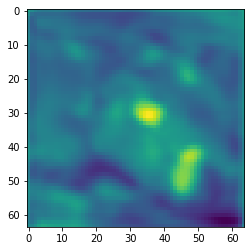

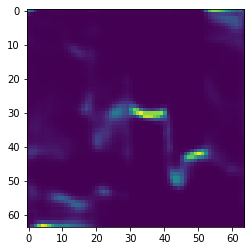

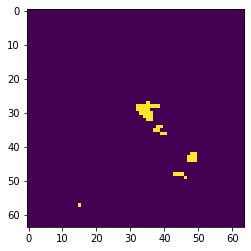

In [41]:
i = 25
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

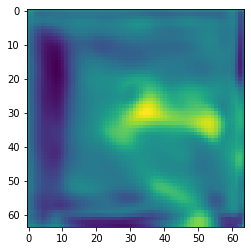

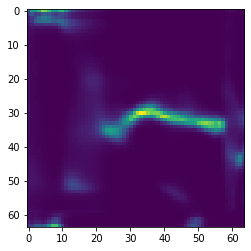

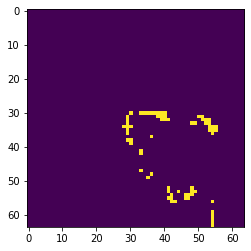

In [42]:
i = 26
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

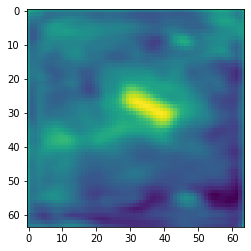

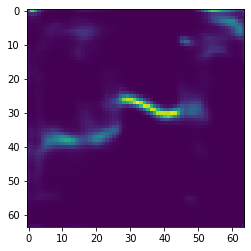

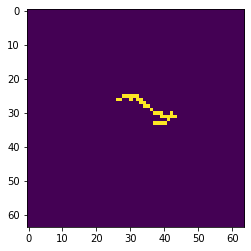

In [44]:
i = 28
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

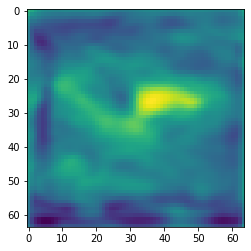

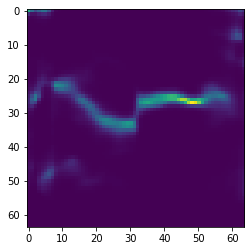

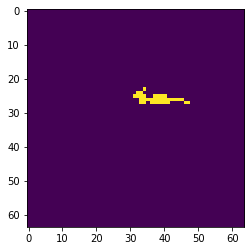

In [45]:
i = 29
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

In [106]:
def return_index(gen,index):
    for i,v in enumerate(gen):
        if i == index:
            return v

pred = unet(drop_bands(return_index(valid_dataloader,0)))

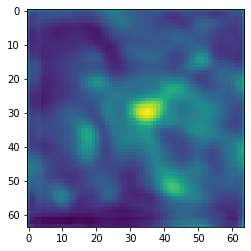

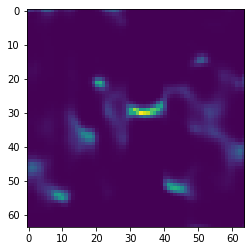

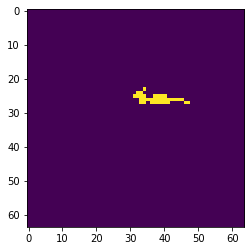

In [65]:
i = 29
plt.imshow(pred[i][0].detach())
plt.show()
m = nn.Softmax(dim=2)
plt.imshow(m(pred).detach()[i][0])
plt.show()
plt.imshow(valid_data['mask'][i][0])

In [81]:
from matplotlib.backends.backend_pdf import PdfPages

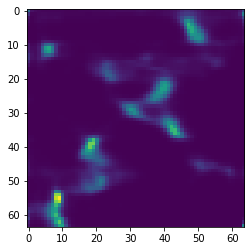

In [88]:
plt.imshow(m(output).detach()[0])

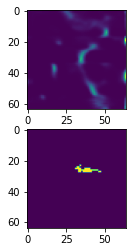

In [121]:
fig = plt.figure()
axis1 = fig.add_subplot(211)
axis1.imshow(m(output).detach()[0])
# plt.show()
axis2 = fig.add_subplot(212)
axis2.imshow(valid_data['mask'][i][0])
plt.show(fig)

In [ ]:
def return_index(gen,index):
    for i,v in enumerate(gen):
        if i == index:
            return v

pred = unet(drop_bands(return_index(valid_dataloader,0)))

In [126]:
for valid_data in valid_dataloader:
    image, mask = valid_data['image'], valid_data['mask']
    print(image.shape)

torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([30, 26, 64, 64])
torch.Size([3, 26, 64, 64])


In [131]:
m(unet(drop_bands(next(iter(valid_dataloader))))).detach()[0][0].shape

torch.Size([64, 64])

In [ ]:
/Users/seancarter/Documents/outputs/predicted9.png

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


/var/folders/sr/k_mmd1z56k707hsy7dx9r96h0000gn/T/ipykernel_13127/3380622041.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
2

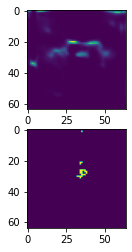

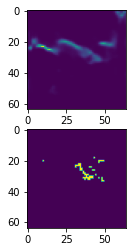

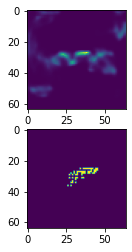

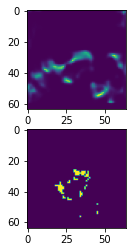

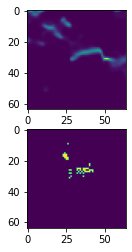

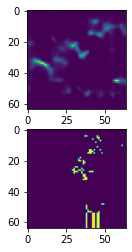

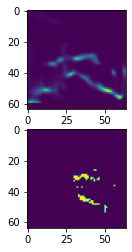

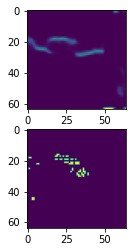

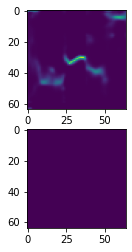

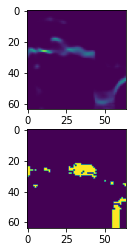

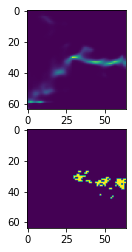

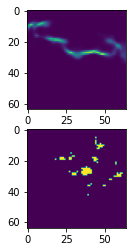

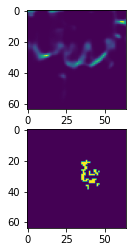

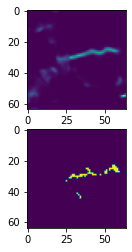

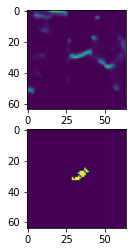

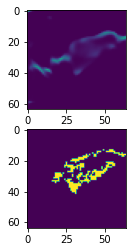

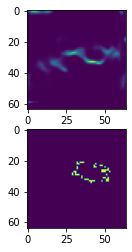

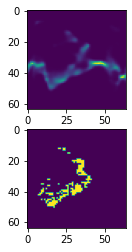

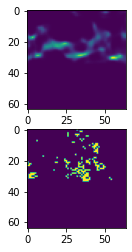

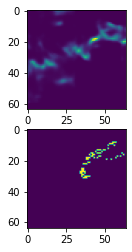

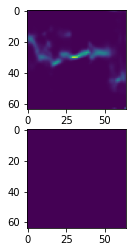

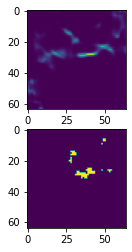

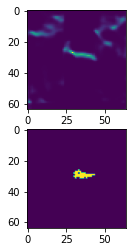

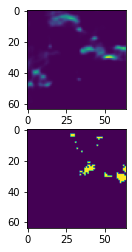

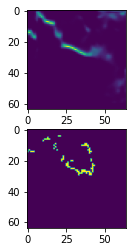

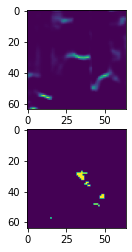

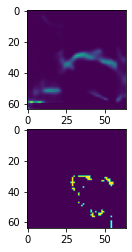

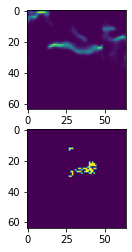

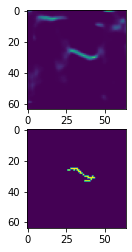

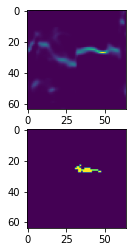

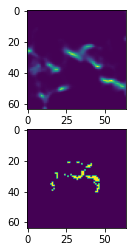

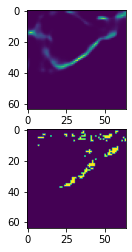

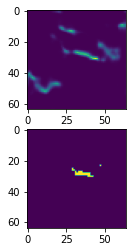

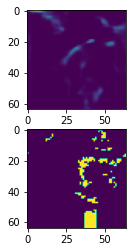

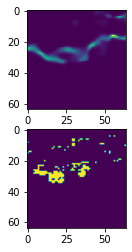

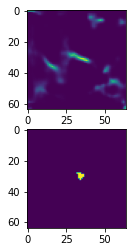

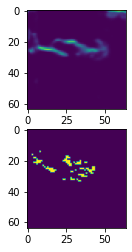

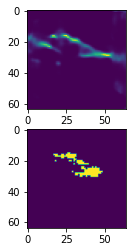

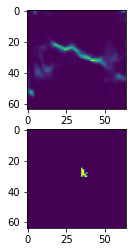

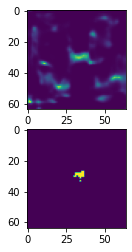

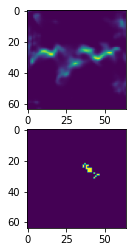

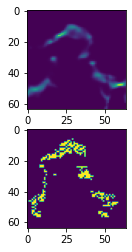

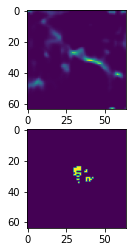

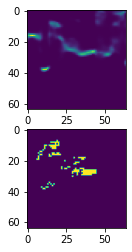

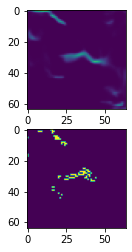

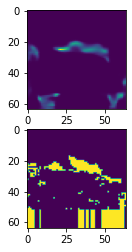

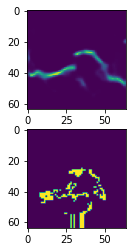

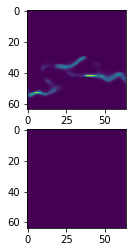

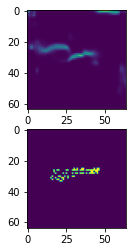

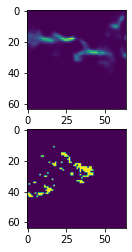

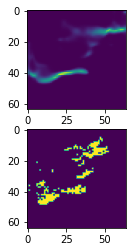

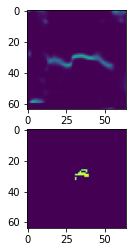

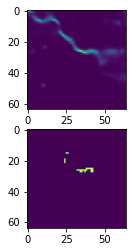

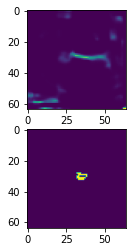

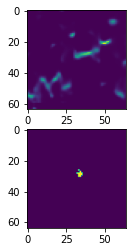

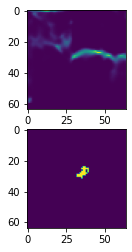

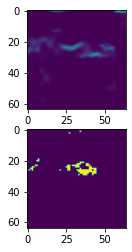

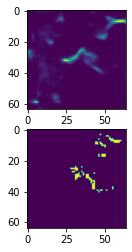

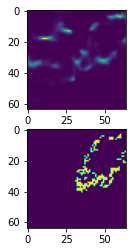

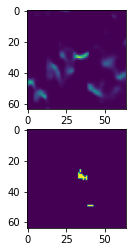

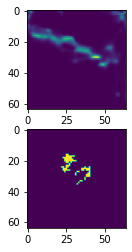

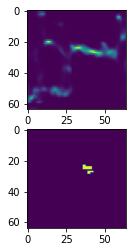

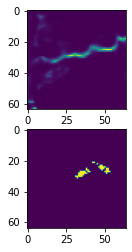

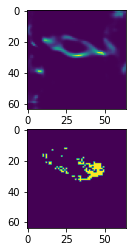

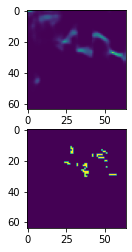

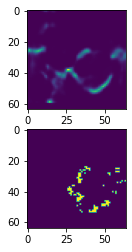

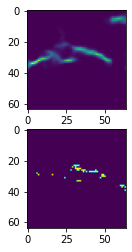

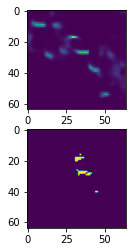

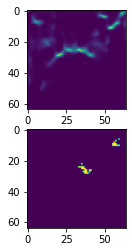

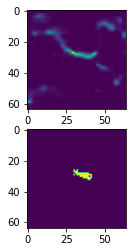

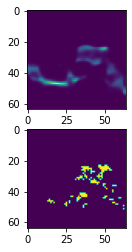

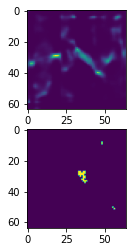

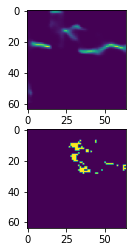

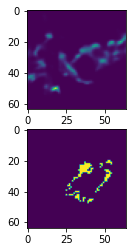

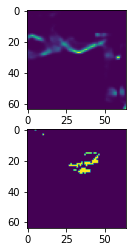

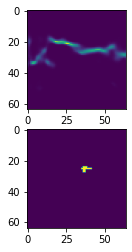

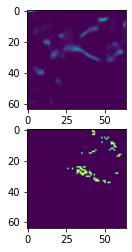

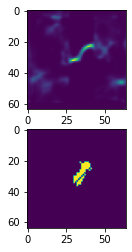

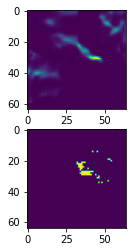

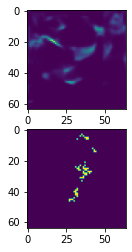

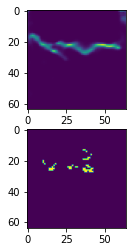

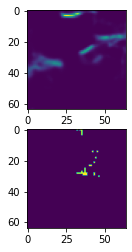

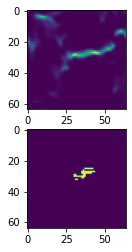

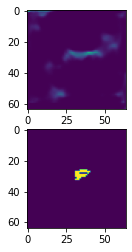

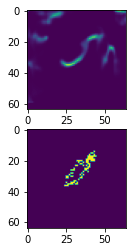

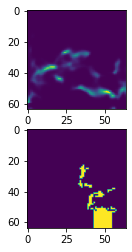

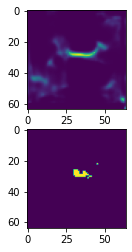

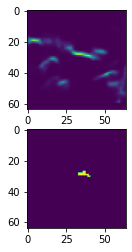

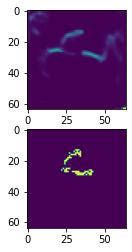

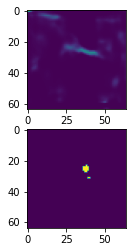

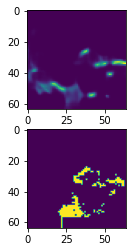

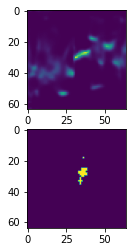

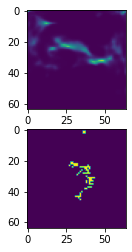

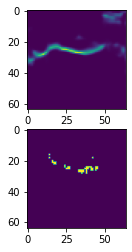

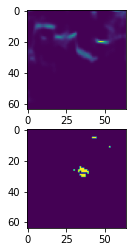

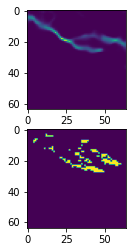

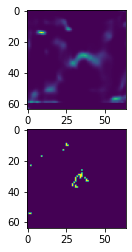

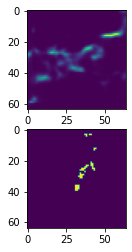

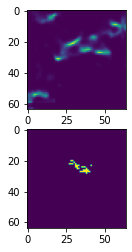

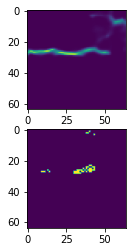

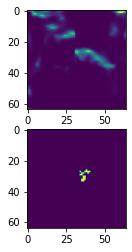

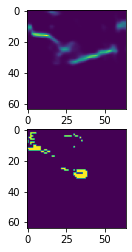

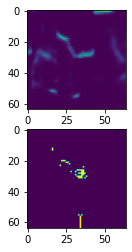

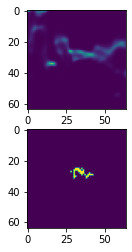

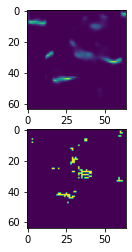

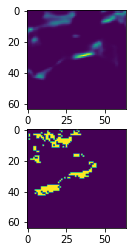

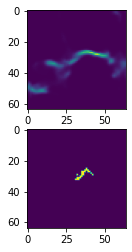

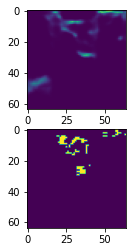

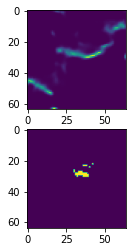

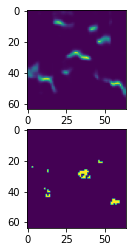

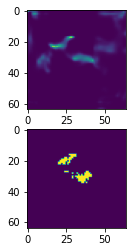

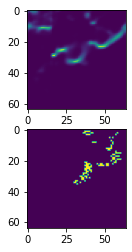

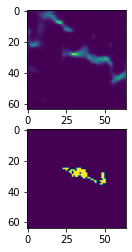

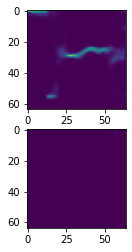

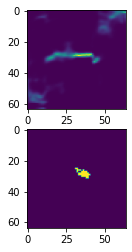

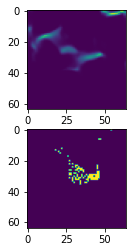

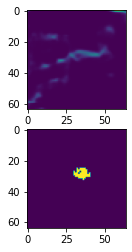

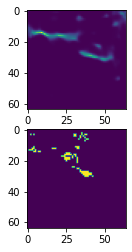

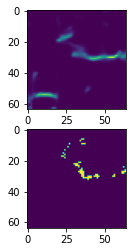

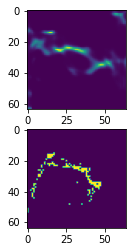

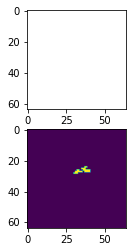

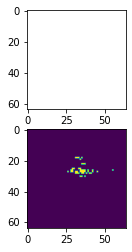

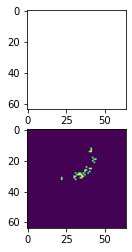

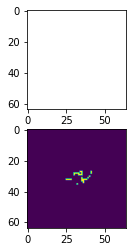

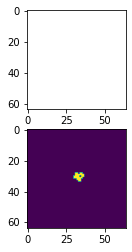

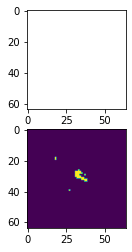

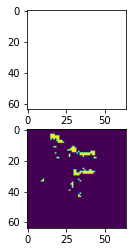

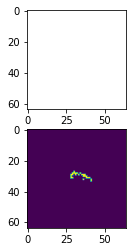

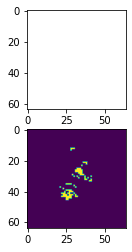

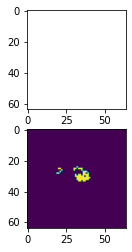

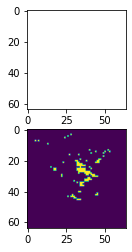

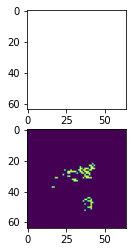

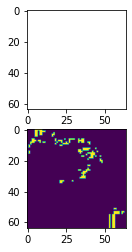

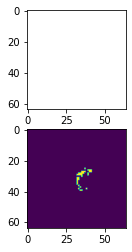

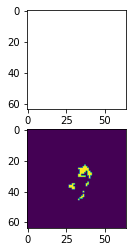

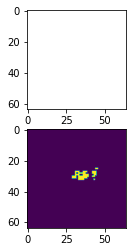

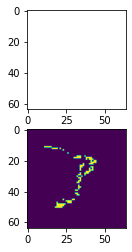

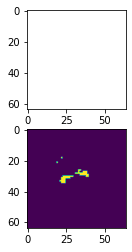

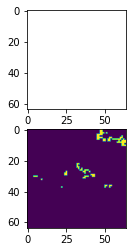

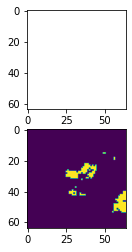

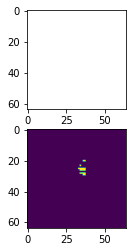

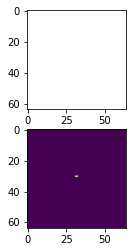

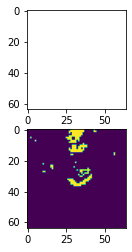

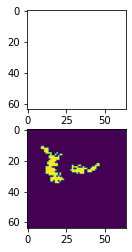

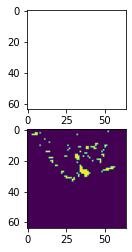

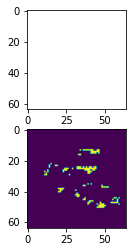

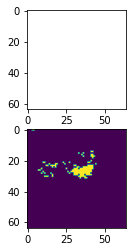

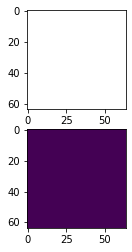

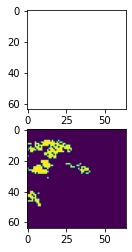

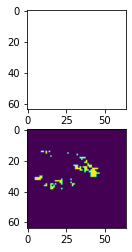

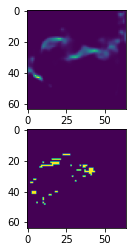

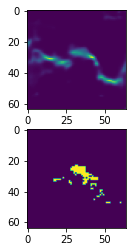

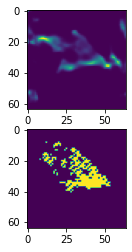

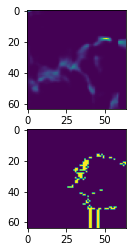

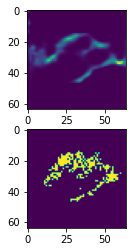

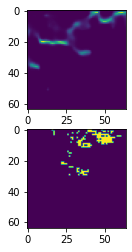

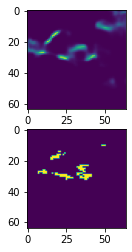

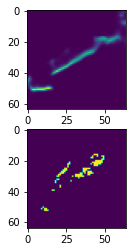

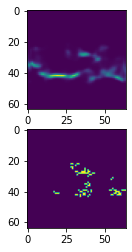

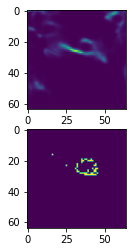

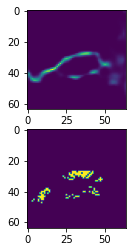

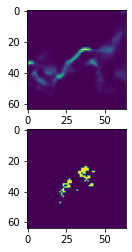

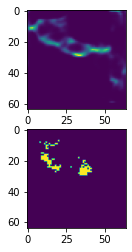

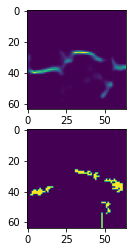

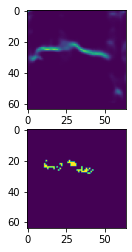

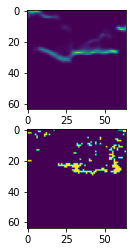

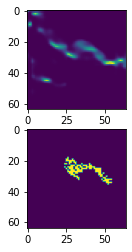

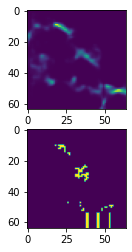

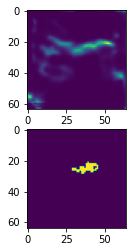

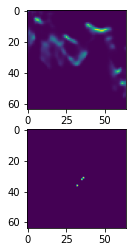

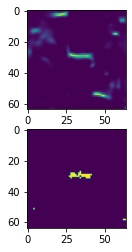

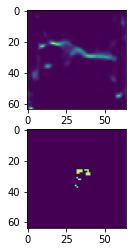

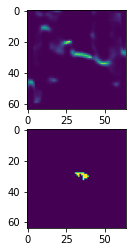

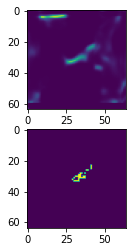

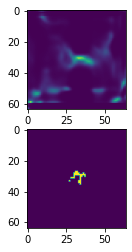

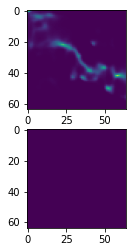

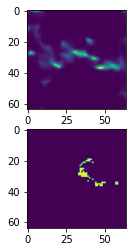

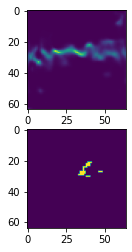

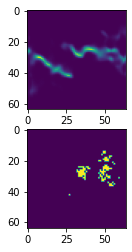

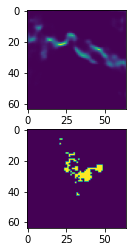

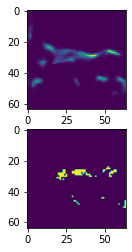

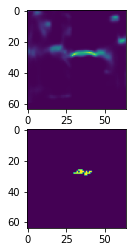

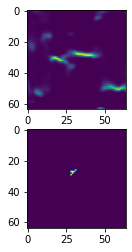

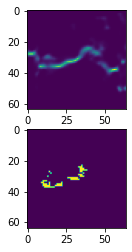

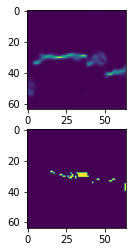

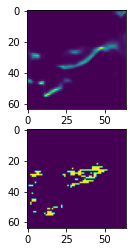

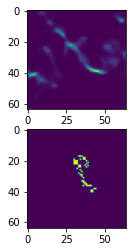

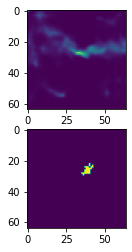

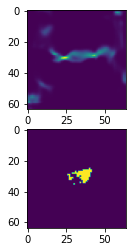

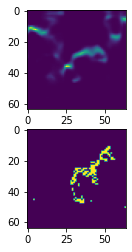

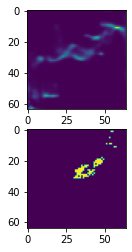

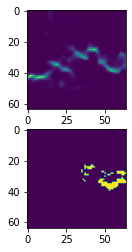

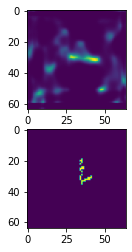

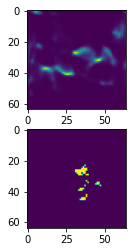

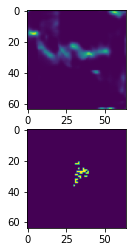

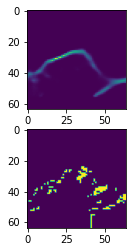

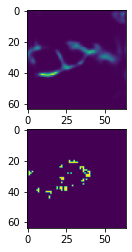

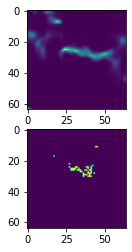

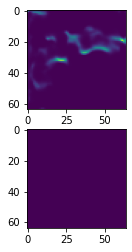

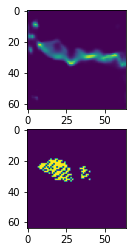

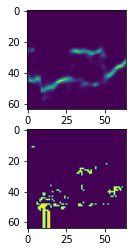

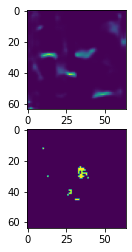

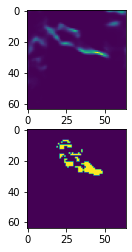

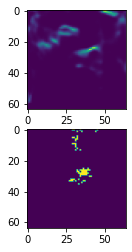

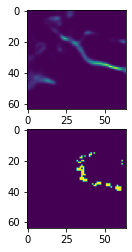

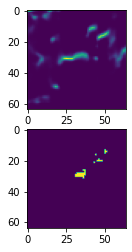

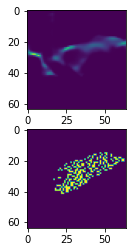

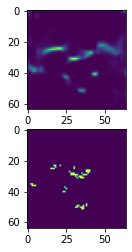

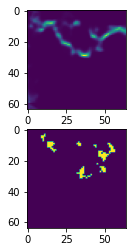

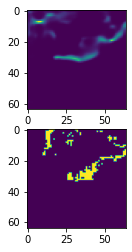

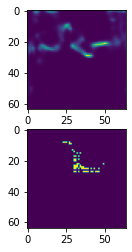

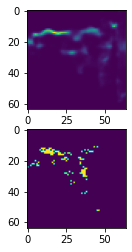

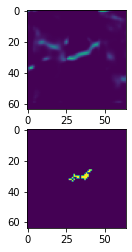

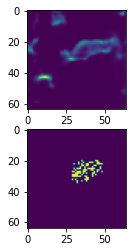

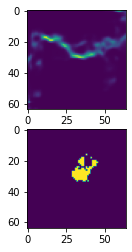

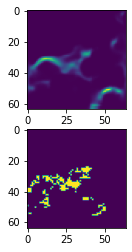

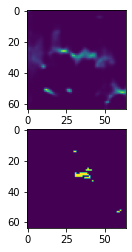

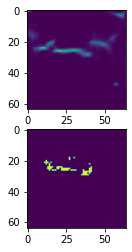

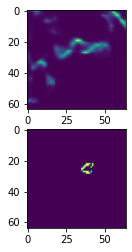

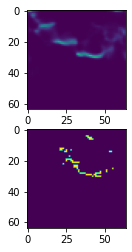

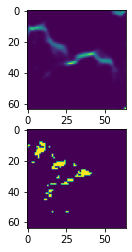

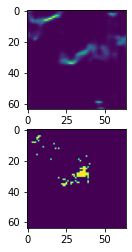

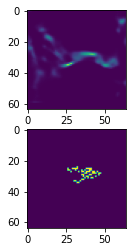

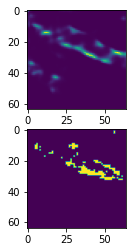

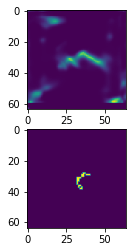

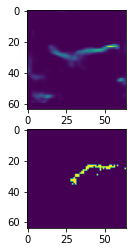

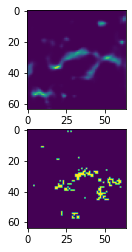

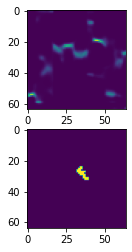

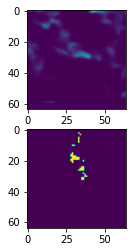

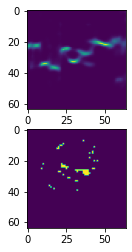

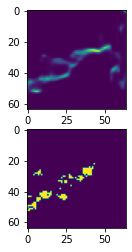

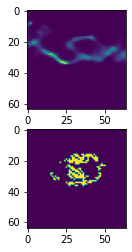

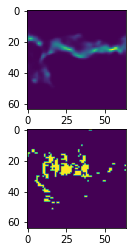

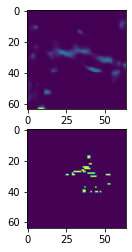

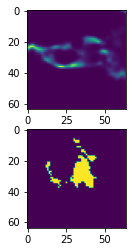

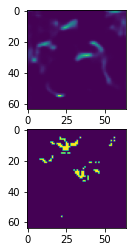

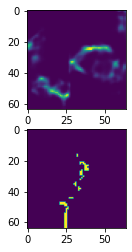

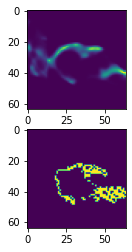

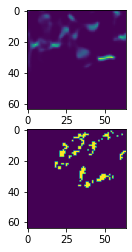

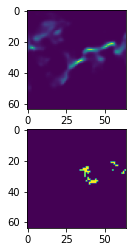

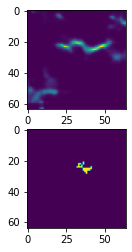

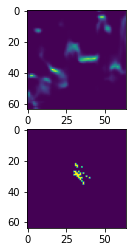

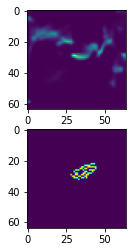

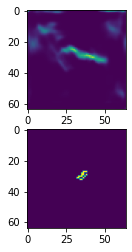

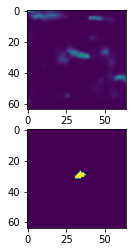

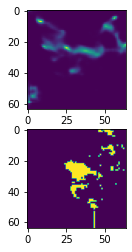

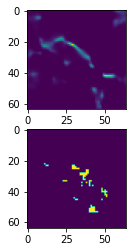

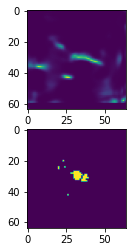

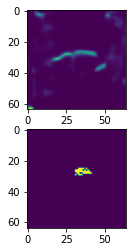

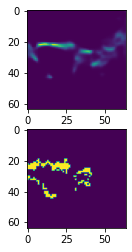

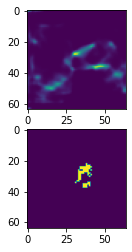

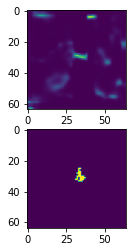

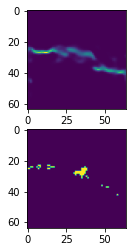

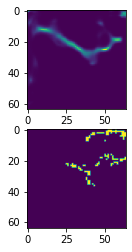

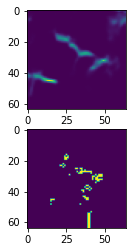

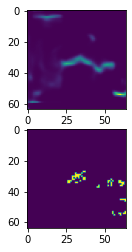

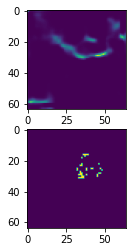

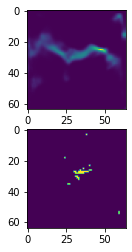

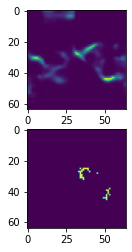

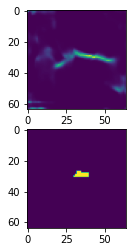

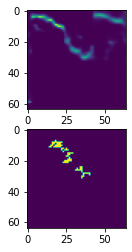

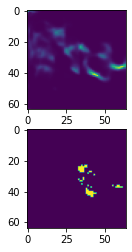

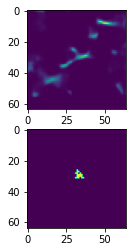

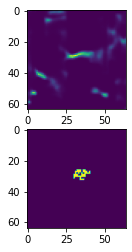

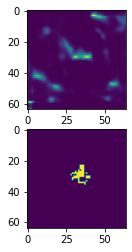

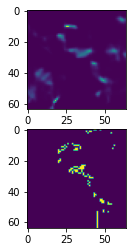

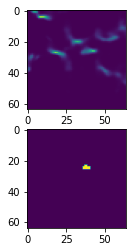

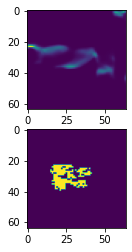

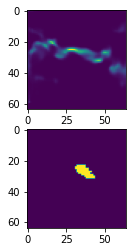

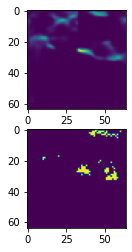

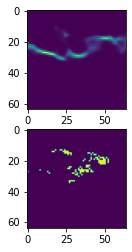

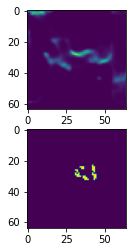

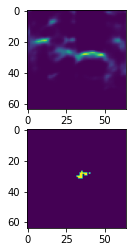

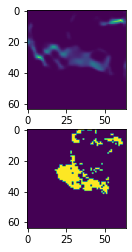

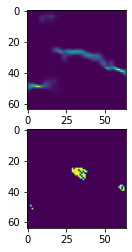

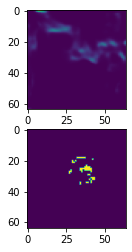

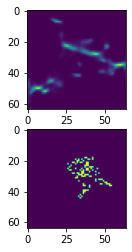

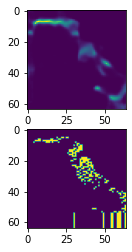

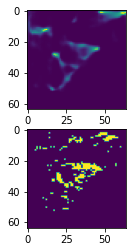

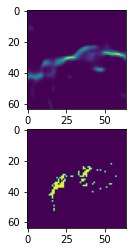

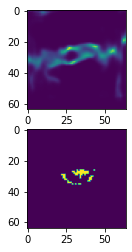

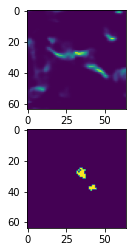

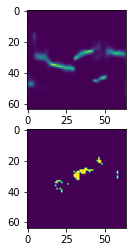

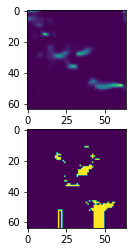

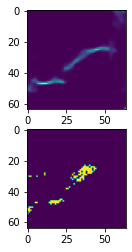

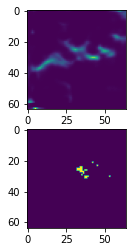

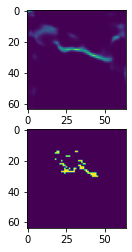

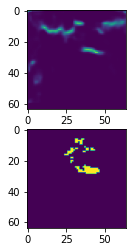

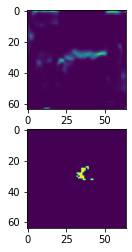

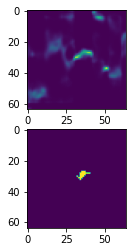

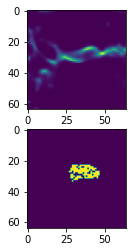

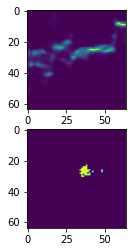

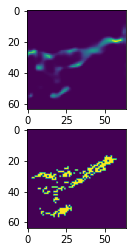

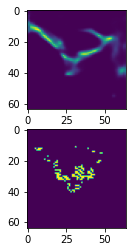

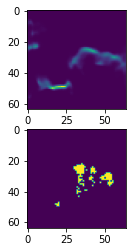

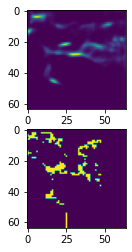

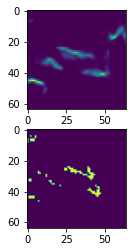

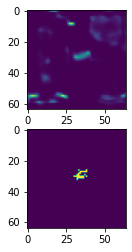

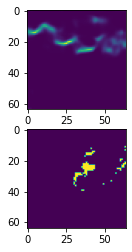

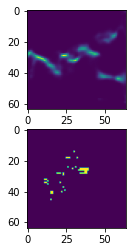

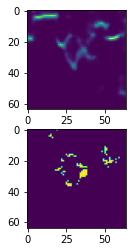

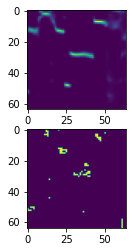

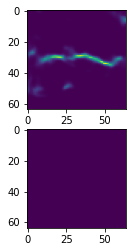

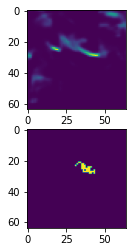

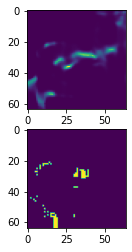

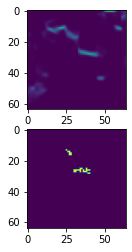

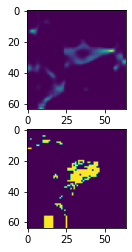

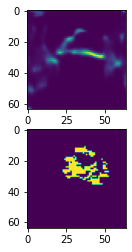

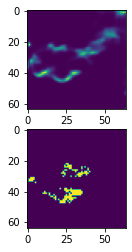

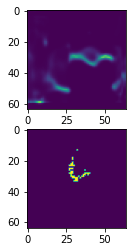

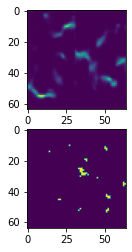

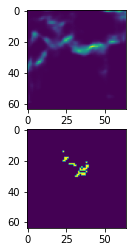

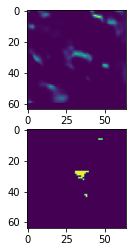

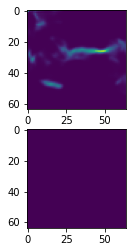

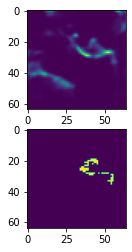

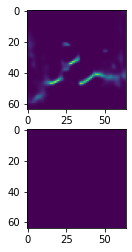

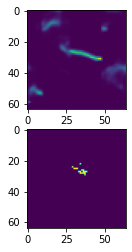

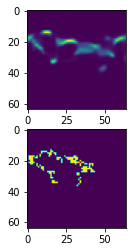

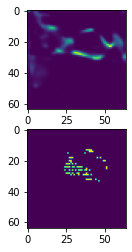

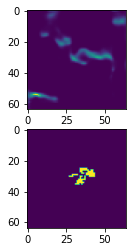

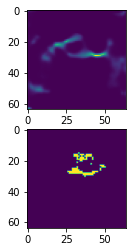

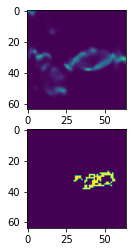

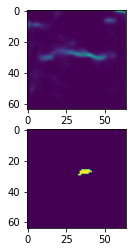

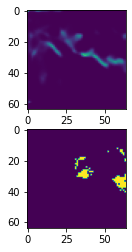

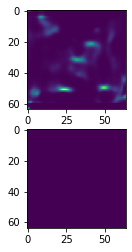

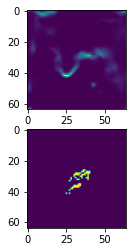

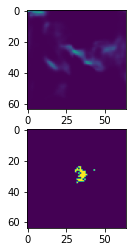

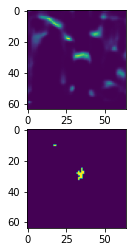

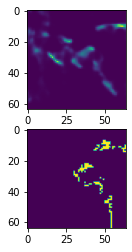

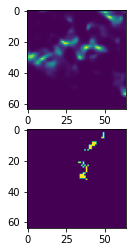

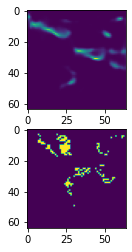

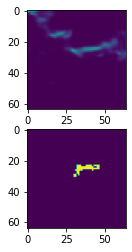

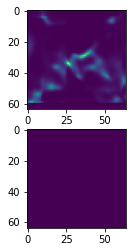

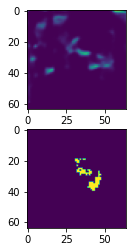

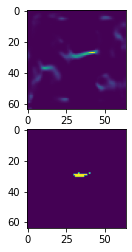

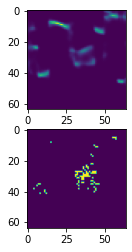

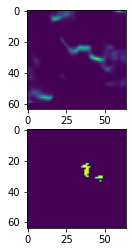

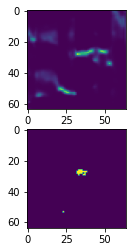

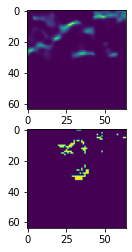

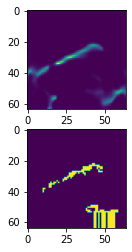

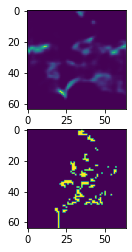

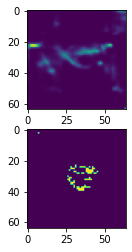

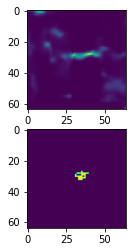

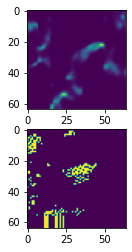

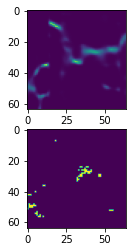

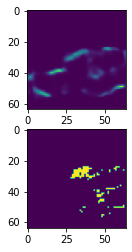

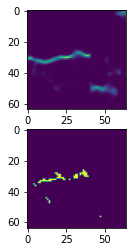

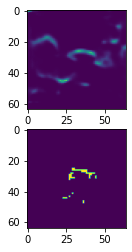

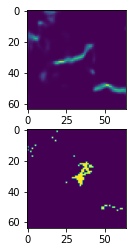

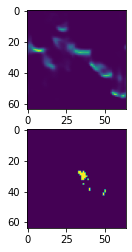

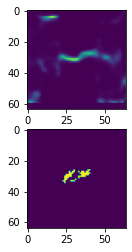

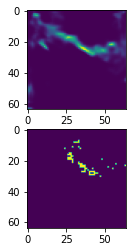

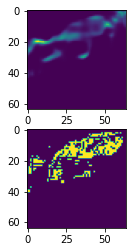

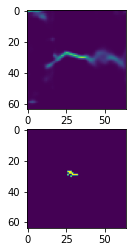

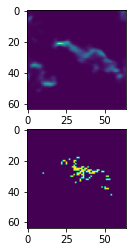

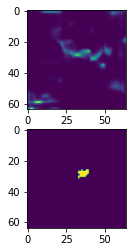

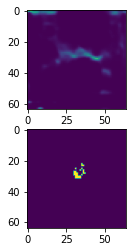

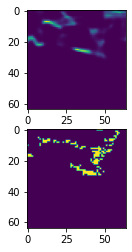

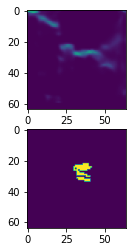

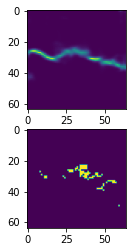

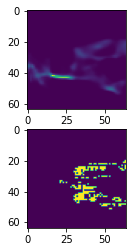

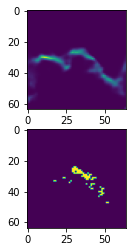

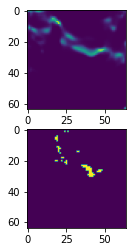

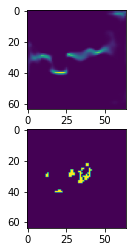

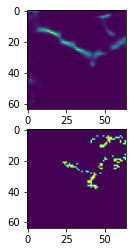

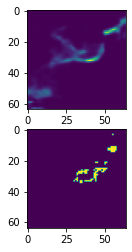

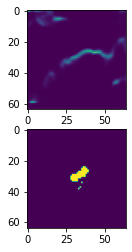

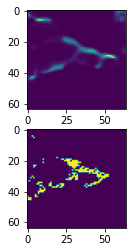

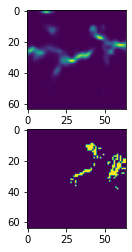

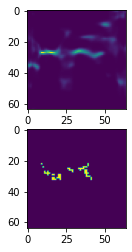

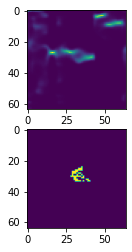

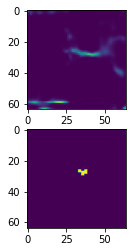

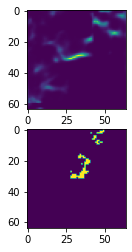

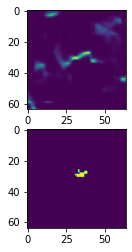

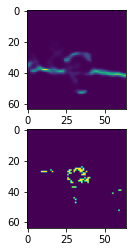

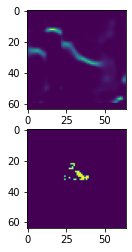

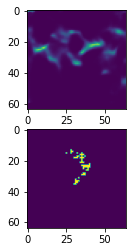

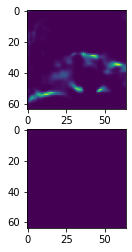

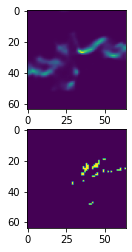

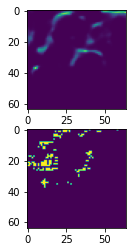

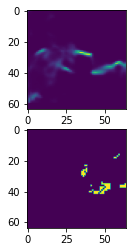

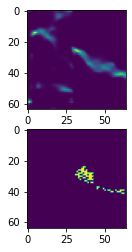

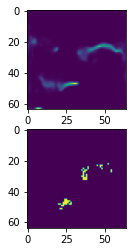

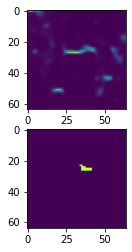

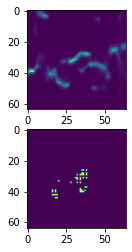

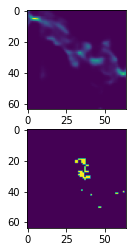

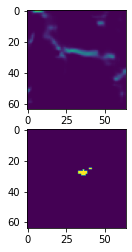

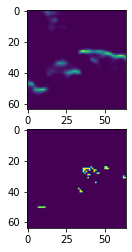

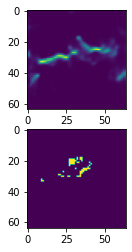

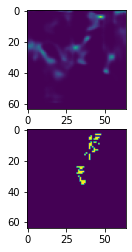

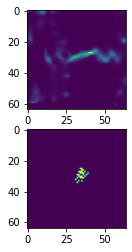

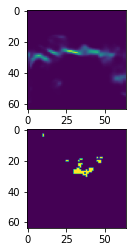

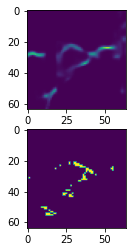

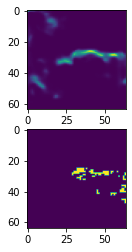

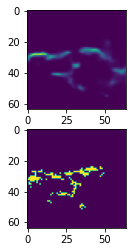

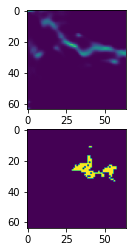

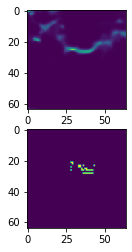

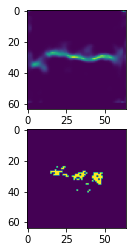

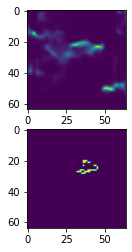

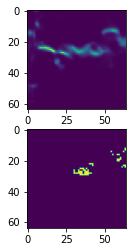

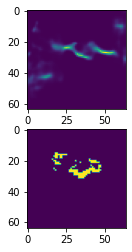

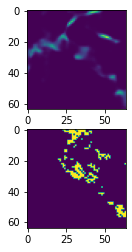

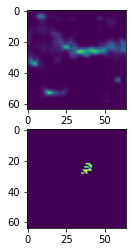

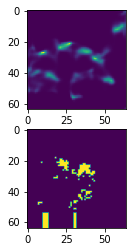

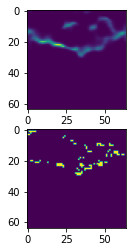

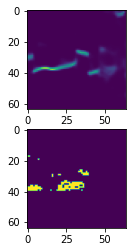

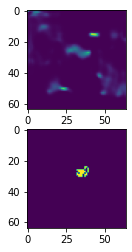

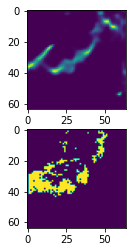

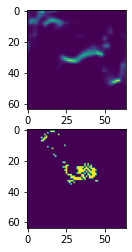

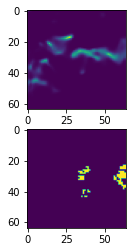

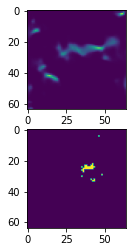

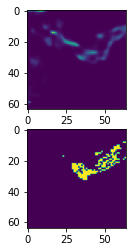

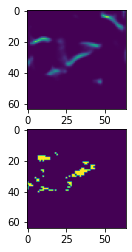

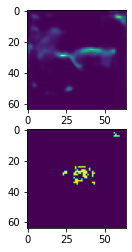

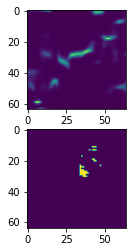

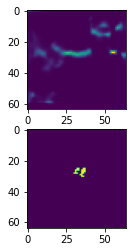

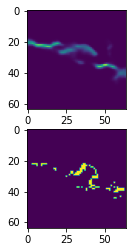

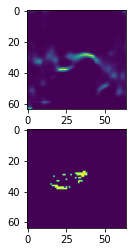

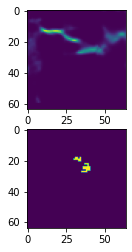

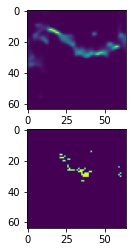

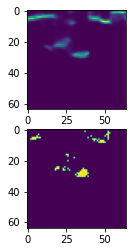

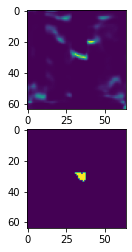

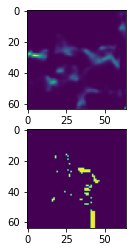

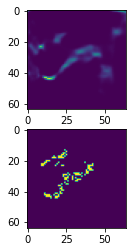

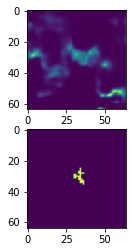

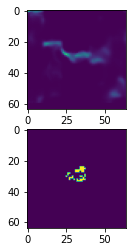

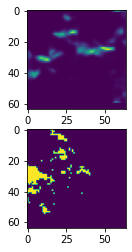

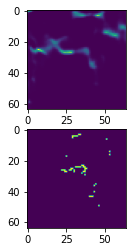

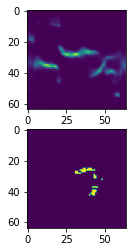

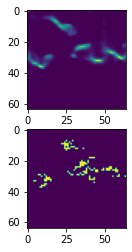

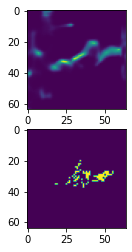

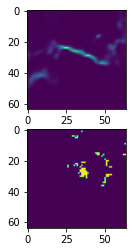

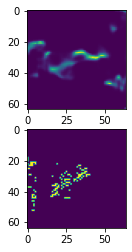

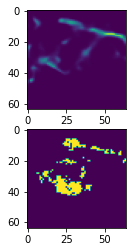

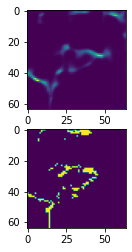

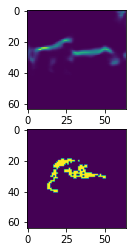

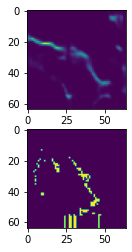

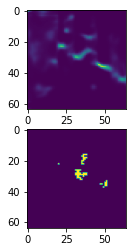

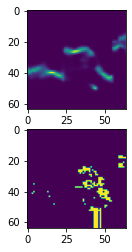

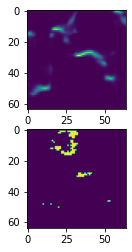

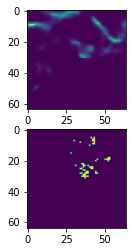

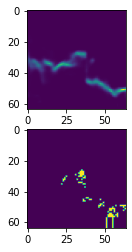

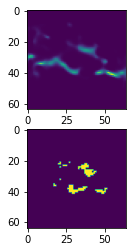

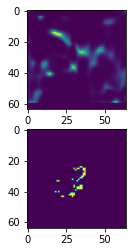

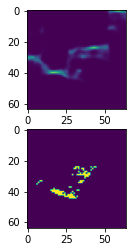

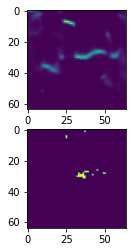

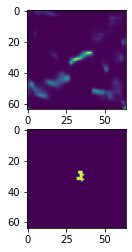

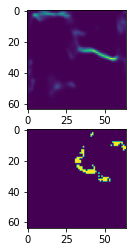

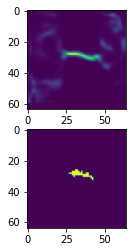

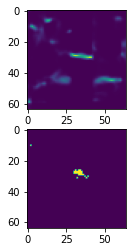

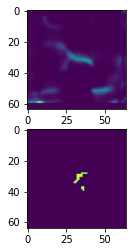

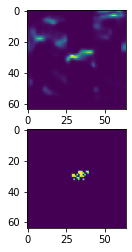

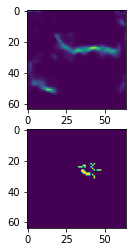

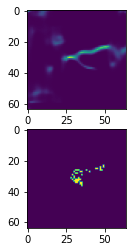

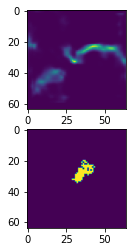

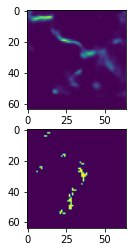

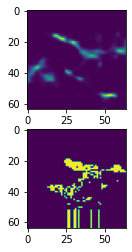

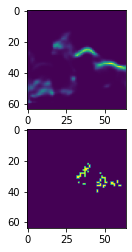

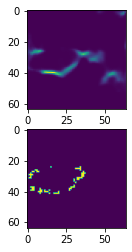

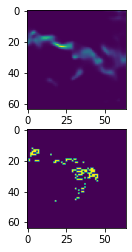

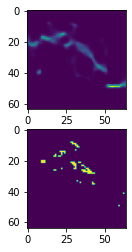

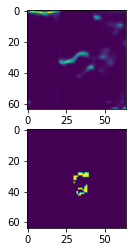

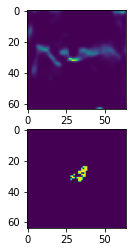

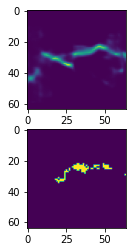

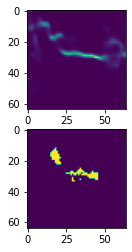

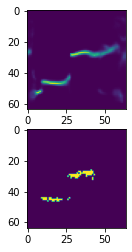

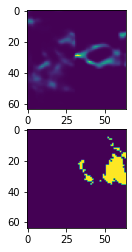

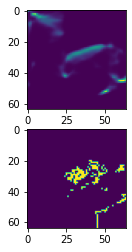

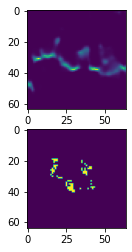

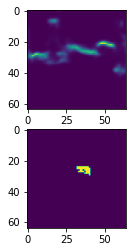

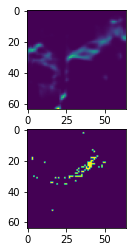

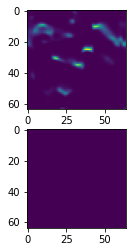

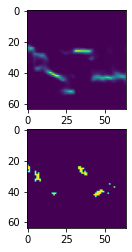

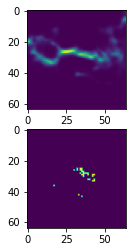

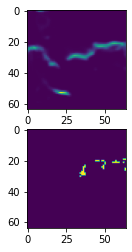

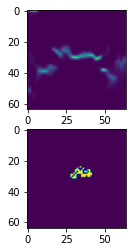

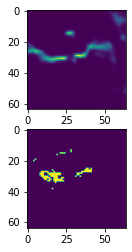

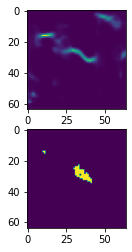

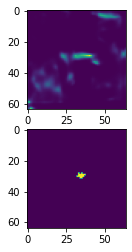

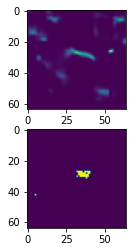

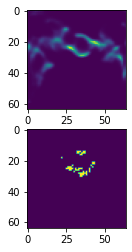

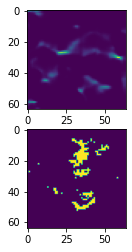

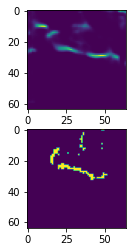

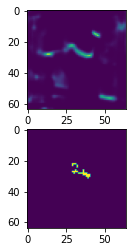

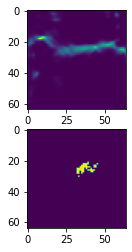

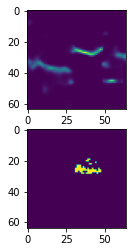

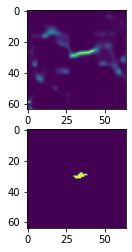

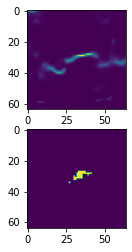

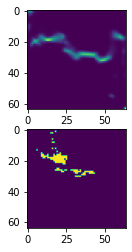

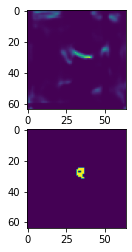

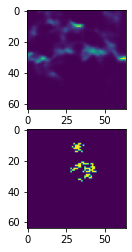

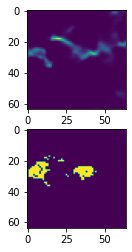

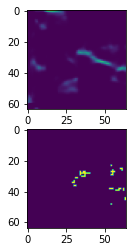

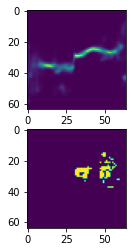

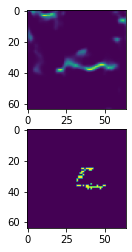

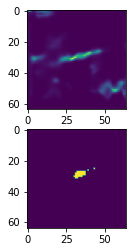

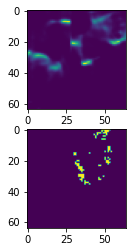

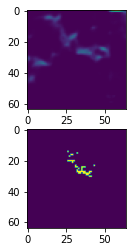

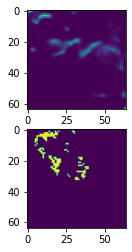

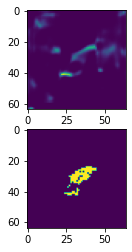

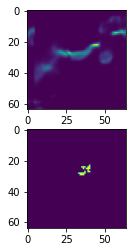

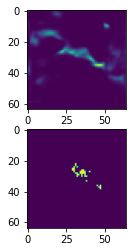

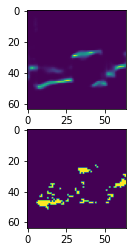

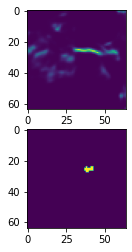

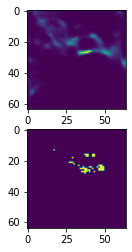

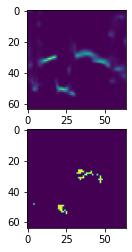

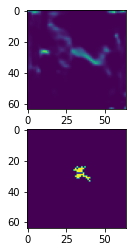

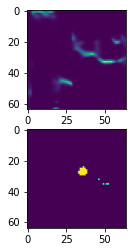

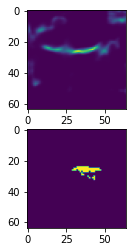

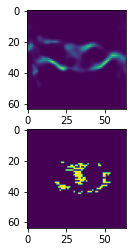

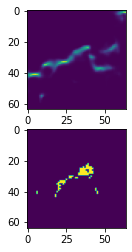

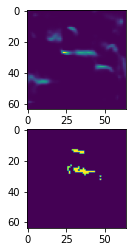

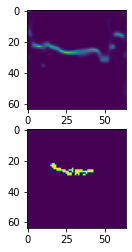

In [140]:
output_num = 1
for valid_data in valid_dataloader:
    image, mask = valid_data['image'], valid_data['mask']
    
    pred = m(unet(drop_bands(valid_data))).detach()
            
    with PdfPages(f'output_{output_num}.pdf') as pdf:
        for i, output in enumerate(pred):
            fig = plt.figure()
            axis1 = fig.add_subplot(211)
            axis1.imshow(output[0])
            # plt.show()
            axis2 = fig.add_subplot(212)
            axis2.imshow(valid_data['mask'][i][0])
            output_fig = fig.get_figure()
            pdf.savefig(output_fig)
            
            
            output_num += 1
            
            print(output_num)
#             fig = plt.figure()
#             axis1 = fig.
#             fig = plt.imshow(m(output).detach()[0]).get_figure()
#             pdf.savefig(fig)

In [70]:
pdf = mpl_pdf.PdfPages("output.pdf")
m = nn.Softmax(dim=2)


#     plt.imshow(m(pred).detach()[i][0])
for fig in xrange(1, plt.gcf().number+1):
    pdf.savefig(fig)
    
pdf.close()

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
